# DCGAN으로 Fashion MNIST 이미지 생성하기<a class="tocSkip">

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-데이터-준비하기" data-toc-modified-id="1.-데이터-준비하기-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. 데이터 준비하기</a></span></li><li><span><a href="#2.-생성자-구현하기" data-toc-modified-id="2.-생성자-구현하기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. 생성자 구현하기</a></span></li><li><span><a href="#3.-판별자-구현하기" data-toc-modified-id="3.-판별자-구현하기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. 판별자 구현하기</a></span></li><li><span><a href="#4.-손실함수와-최적화-함수" data-toc-modified-id="4.-손실함수와-최적화-함수-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. 손실함수와 최적화 함수</a></span><ul class="toc-item"><li><span><a href="#4.1.-손실함수(loss-function)" data-toc-modified-id="4.1.-손실함수(loss-function)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>4.1. 손실함수(loss function)</a></span></li><li><span><a href="#4.2.-최적화-함수(optimizer)" data-toc-modified-id="4.2.-최적화-함수(optimizer)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>4.2. 최적화 함수(optimizer)</a></span></li></ul></li><li><span><a href="#5.-훈련과정-설계" data-toc-modified-id="5.-훈련과정-설계-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>5. 훈련과정 설계</a></span></li><li><span><a href="#6.-학습-시키기" data-toc-modified-id="6.-학습-시키기-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>6. 학습 시키기</a></span></li></ul></div>

# 1. 데이터 준비하기
Fashion MNIST 데이터를 불러와서 전처리를 합니다.

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
#  y_train, y_test 데이터는 사용하지 않습니다.
(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
# 흑백 이미지이므로 shape 마지막에 채널 값 1을 추가
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

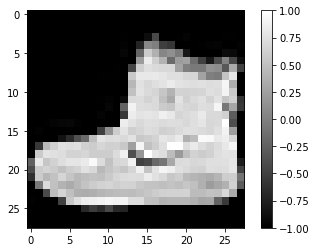

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

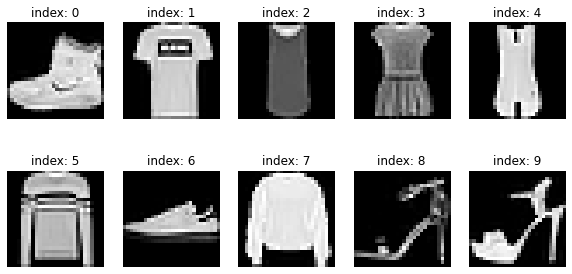

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

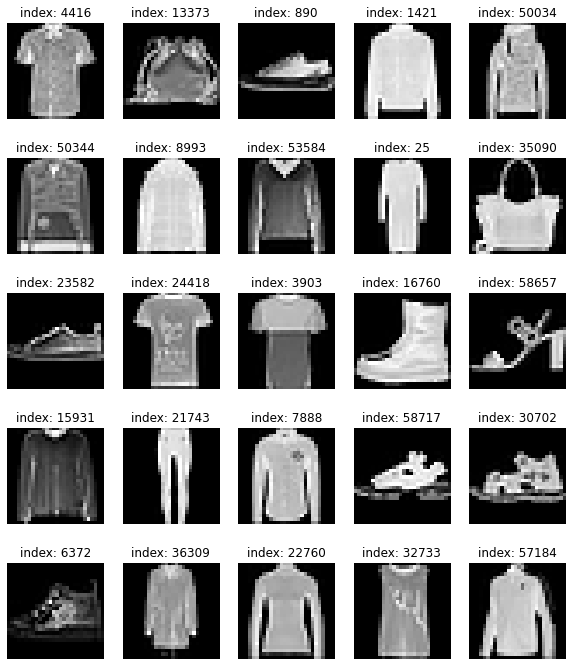

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 60000  # 전체 데이터를 섞기 위해 60,000으로 설정
BATCH_SIZE = 256     # 한 번에 학습할 데이터의 양

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 생성자 구현하기
생성자(Generator)는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해 냅니다. 즉, 무에서 유를 창조하는 것과 같은 역할을 합니다.
- Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다. 이 모델에서는 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나갑니다.
- BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다.
- 중간층들의 활성화 함수는 모두 LeakyReLU를 사용하였고, 마지막 층에는 활성화 함수로 tanh를 사용했습니다. 이는 우리가 -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [14]:
# 랜덤 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [15]:
# 생성자 모델에 입력값으로 노이즈를 넣고 결과 이미지 생성
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

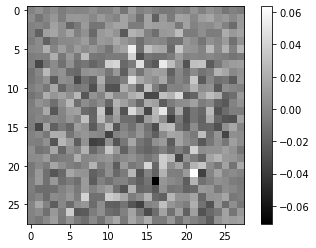

In [16]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# 3. 판별자 구현하기
판별자(Discriminator)는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실숫값으로 출력합니다.
- Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다. 이 모델에서는 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됩니다.
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다.
- 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
# 위에서 생성한 가짜 이미지를 판별자에 입력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00085404]], dtype=float32)>

# 4. 손실함수와 최적화 함수
## 4.1. 손실함수(loss function)
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다. Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같습니다.
- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 4.2. 최적화 함수(optimizer)
생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 합니다. 또한, 학습의 진전 과정을 확인하기 위해 seed가 고정된 100차원의 노이즈를 총 16개, 즉 (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 5. 훈련과정 설계
하나의 미니배치 당 진행할 train_step 함수를 만듭니다.
- (1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator가
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [30]:
# @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다.
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만듭니다. 아까 만들어 놓았던 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

In [31]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다.

In [32]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다. tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.

In [33]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 6. 학습 시키기
이상 한 단계를 학습하는 train_step(), 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습 과정을 시각화하는 draw_train_history(), 그리고 모델을 저장하기 위한 checkpoint까지 모두 준비가 되었으니, 이것들을 train()이라는 하나의 함수로 합치고 학습을 진행한다.

In [34]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [35]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

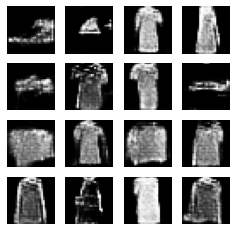

Time for training : 614 sec


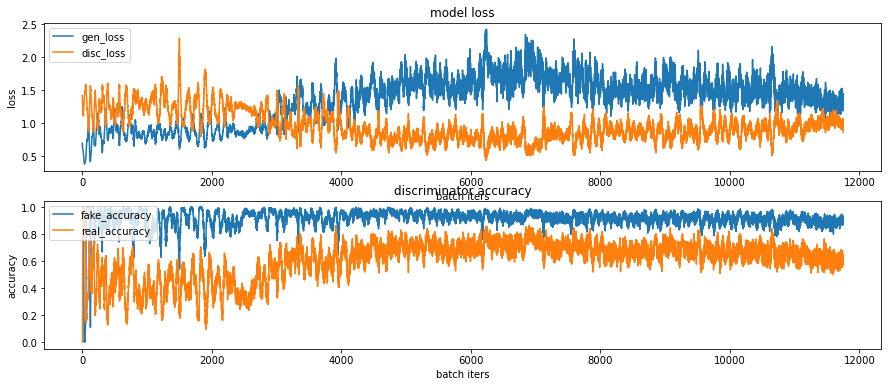

CPU times: user 4min 16s, sys: 13.1 s, total: 4min 29s
Wall time: 10min 14s


In [36]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [37]:
# gif 파일로 학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 ssac21 ssac21 1310970  2월 18 15:26 /home/ssac21/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


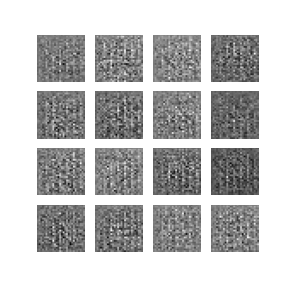